## Machine Learning and Computational Statistics
# Final Project: Leon Kalderon

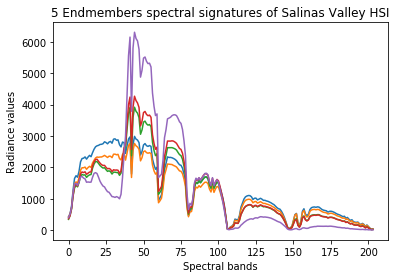

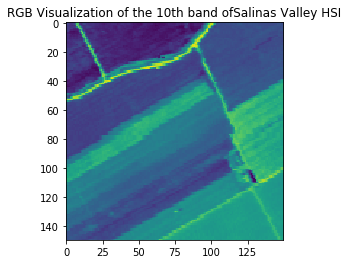

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
import cvxopt as cx
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
Salinas = sio.loadmat('Salinas_hyperspectral.mat')
HSI = Salinas['Salinas_Image'] #Salinas HSI : 150x150x204
endmembers = Salinas['Salinas_endmembers'] # Endmember's matrix: 204x5

fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('5 Endmembers spectral signatures of Salinas Valley HSI')
plt.show()

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band ofSalinas Valley HSI')
plt.show()

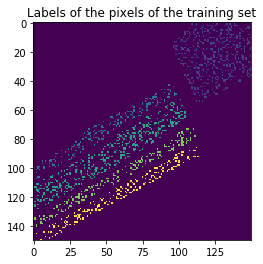

In [2]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels.mat')
Training_Set = (np.reshape(Salinas_labels['Training_Set'],(150,150))).T
Test_Set = (np.reshape(Salinas_labels['Test_Set'],(150,150))).T
Operational_Set = (np.reshape(Salinas_labels['Operational_Set'],(150,150))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

## Part 1 Spectral unmixing (SU):

First of all, we define all the functions that we need.

In [3]:
#store the pixels with their corresponding class into a matrix 150x150.
#Thus, we'll be able to 'mask' our image(HSI 150x150X204) and proccess only the pixels that belong to a class.
#the integer 0 denotes that a pixel does not have a specific class.
pixel_class = sio.loadmat('Salina_ground_truth.mat')['Labels']


#this function creates the matricies that contain the data of abundance maps.
#parameteres:
#thetas: 150x150x5 matrix
#pixel_class: the class of each pixel(150x150), so we store on the AbMap(i) only the thetas of non-zero class pixels
#returns:
#five matricies 150x150 with the corresponding theta.
#calls the fucntion plot_abundance_maps() that plots the AbMaps
def create_abundance_map(thetas, pixel_class):
    #define the 5 matricies with the Abundance maps
    AbMap1 = np.zeros((150,150))
    AbMap2 = np.zeros((150,150))
    AbMap3 = np.zeros((150,150))
    AbMap4 = np.zeros((150,150))
    AbMap5 = np.zeros((150,150))
    
    #fill each AM with the correspoinding thetas
    for i in range(0,150):
        for j in range(0,150):
            if pixel_class[i,j] != 0:        
                AbMap1[i,j] = thetas[i,j][0]
                AbMap2[i,j] = thetas[i,j][1]
                AbMap3[i,j] = thetas[i,j][2]
                AbMap4[i,j] = thetas[i,j][3]
                AbMap5[i,j] = thetas[i,j][4]
        #for thetas < 0 we assign them as 0
        AbMap1[AbMap1<0] = 0
        AbMap2[AbMap2<0] = 0
        AbMap3[AbMap3<0] = 0
        AbMap4[AbMap4<0] = 0
        AbMap5[AbMap5<0] = 0
    #call the function that plot the AMs
    plot_abundance_maps(AbMap1, AbMap2, AbMap3, AbMap4, AbMap5)
    
    return AbMap1, AbMap2, AbMap3, AbMap4, AbMap5


def plot_abundance_maps(AbMap1, AbMap2, AbMap3, AbMap4, AbMap5):
    f, axarr = plt.subplots(2,3)
    axarr[0,0].set_title('1rst Abund_Map')
    axarr[0,0].imshow(AbMap1)
    axarr[0,1].set_title('2nd Abund_Map')
    axarr[0,1].imshow(AbMap2)
    axarr[0,2].set_title('3rd Abund_Map')
    axarr[0,2].imshow(AbMap3)
    axarr[1,0].set_title('4rth Abund_Map')
    axarr[1,0].imshow(AbMap4)
    axarr[1,1].set_title('5th Abund_Map')
    axarr[1,1].imshow(AbMap5)
    axarr[1,2].set_title('Pixel\'s Class')
    axarr[1,2].imshow(pixel_class)
    f.subplots_adjust(hspace=0.8)
    
#the functio below calculates the reconstruction_error()
#theta_list = weights(models' output)
#y = pixel's true values
#X = pure pixels
def reconstruction_error(theta_list, pixels = HSI, X = endmembers, pixel_class = pixel_class):
    sum_error = 0
    y_hat = np.zeros(shape=(1, 204), dtype=object)
    for i in range(0,150):
        for j in range(0,150):
            if pixel_class[i][j] != 0:
                y = HSI[i,j,:]
                yhat = X.dot(theta_list[i,j][:])
                error = ((y - yhat).T).dot(y - yhat)
                sum_error += error    
    
    count_non_zero = np.count_nonzero(pixel_class)
    return sum_error/count_non_zero

# (a) Least Squares Method

The reconstruction error of the Least squares method is:  164596.193994

Abundance Maps:


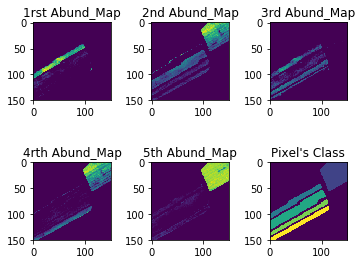

In [4]:
#calculate the parameters with OLS method.
#store the thetas(parameters) on the thetas_LS list
thetas_LS = np.empty(shape=(150, 150), dtype=object)
X = endmembers
Xinv = np.linalg.inv(np.dot(X.T,X))
for i in range(0,150):
    for j in range(0,150):
        #we want to calculate the thetas only for the nonzero class pixels
        if pixel_class[i,j] !=0:
            theta = Xinv.dot(X.T).dot(HSI[i,j,:])
            thetas_LS[i,j] = theta
        else:
            thetas_LS[i,j] = [0, 0, 0, 0, 0]            
            

create_abundance_map(thetas_LS, pixel_class)
print('The reconstruction error of the Least squares method is: ', reconstruction_error(thetas_LS))
print()
print('Abundance Maps:')

# (b) Least Squares Method with constrain all coefficients Sum to One

https://scaron.info/blog/quadratic-programming-in-python.html
this link explains at length how we define the constrains of each method. 

The reconstruction error of Least squares Sum-To-One constrain is:  248397.171391

Abundance Maps:


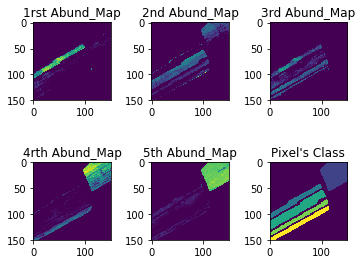

In [5]:
#(B) LS with sum to one weights
thetas_sumToOne = np.empty(shape=(150, 150), dtype=object)

#contrains
P = cx.matrix(2*(X.T).dot(X))
A = cx.matrix([1.0, 1.0, 1.0, 1.0, 1.0]).T
b = cx.matrix([1.0])

for i in range(0,150):
    for j in range(0,150):
        if pixel_class[i,j] != 0:
            y = HSI[i,j,:]
            q = cx.matrix(-2*(y.T).dot(X))
            thetas_sumToOne[i,j] = np.array(cx.solvers.qp(P, q, G=None, h=None, A=A, b=b)['x']).flatten('false')
            
create_abundance_map(thetas_sumToOne, pixel_class)
print('The reconstruction error of Least squares Sum-To-One constrain is: ', reconstruction_error(thetas_sumToOne))
print()
print('Abundance Maps:')

# (c) Least Squares Method with constrain all coefficients are non-negative

The reconstruction error of Least squares Non-Negative constrain is:  1320126.70386

Abundance Maps:


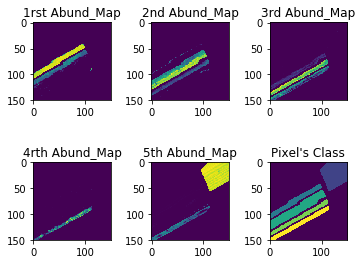

In [6]:
#(C) LS with non-negative weights
#constrains:
G = cx.spdiag([-1.0, -1.0, -1.0, -1.0, -1.0])
h = cx.matrix([0.0, 0.0, 0.0, 0.0, 0.0])
P = cx.matrix(2*(X.T).dot(X))

cx.solvers.options['show_progress'] = False
thetas_noneg = np.empty(shape=(150, 150), dtype=object)

for i in range(0,150):
    for j in range(0,150):
        if pixel_class[i,j] != 0:
            y = HSI[i,j,:]
            q = cx.matrix(-2*(y.T).dot(X))
            thetas_noneg[i,j] = np.array(cx.solvers.qp(P, q, G=G, h=h, A = None , b = None)['x']).flatten('false')

create_abundance_map(thetas_noneg, pixel_class)
print('The reconstruction error of Least squares Non-Negative constrain is: ', reconstruction_error(thetas_noneg))
print()
print('Abundance Maps:')

# (d) Least Squares Method with constrains all coefficients are non-negative and sum-to-one

The reconstruction error of Least squares Non-Negative and Sum-To-One constrain is:  8172556.76401

Abundance Maps:


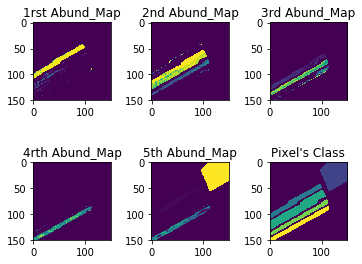

In [7]:
#(D) LS with non-negative and sum-to-one weights
X = endmembers
#contrains
G = cx.matrix([-1.0, -1.0, -1.0, -1.0, -1.0])
I = cx.spdiag(G)
h = cx.matrix([0.0, 0.0, 0.0, 0.0, 0.0])
P = cx.matrix(2*(X.T).dot(X))
A = cx.matrix([1.0, 1.0, 1.0, 1.0, 1.0]).T
b = cx.matrix([1.0])
thetas_LS_NonNeg_St1 = np.empty( shape=(150, 150),dtype=object)

for i in range(0,150):
    for j in range(0,150):
        y = HSI[i,j,:]
        q = cx.matrix(-2*(y.T).dot(X))
        thetas_LS_NonNeg_St1[i,j] = np.array(cx.solvers.qp(P, q, G=I, h=h, A = A , b = b)['x']).flatten('false')
        
create_abundance_map(thetas_LS_NonNeg_St1, pixel_class)
print('The reconstruction error of Least squares Non-Negative and Sum-To-One constrain is: ', reconstruction_error(thetas_LS_NonNeg_St1))
print()
print('Abundance Maps:')    

From the above abundance maps we can observe the weight of each pure material in each pixel.

When we set constrains, the weights of the dominant pure materials take bigger values and the less dominant smaller values.

Thus, at the last case(non negative and SumToOne constrain), the Abundance Maps shows us which pure meterial is more dominant on each non-zero class pixel. 

It makes sense that when we set more constrains the recunstruction error becomes bigger.
We constrain the cost function's minimazation to a spesific region r. Thus, constraint minimization returns the point θ’ where J(θ)(cost function) is min. in region r.


As the region r becomes smaller the reconstraction error becomes bigger because:

Region J(θ) without constrain = R

Region J(θ) with Sum to One constrain = r < R

Region J(θ) with Non-Negative coefficients constrain = r' < r

Region J(θ) with Non-Negative and Sum-to-One coefficients constrain = r'' < r'.

min θ∈R J(θ) ≤ min θ∈r J(θ) ≤ min θ∈r' J(θ) ≤ min θ∈r'' J(θ)

# Part 2 Classification
## (A)

We define the functions that we need for the implementation of the next questions.

In [6]:
import sklearn.model_selection as ms
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

#Define a function that filters the HSI matrix for a given 'Mask' (Training_Set, Test_Set, Operational_Set)
#returns: 
#HSI_masked: an array with all the non-zero-class pixels of the mask (e.g. dimensions = num_pixelsX204)
#Y: the corresponding class of each pixel
def filter_Mask(HSI, mask):
    temp = np.zeros([150,150])
    temp[mask>0] = 1 
    len_HSI = np.sum(temp)
    HSI_masked = np.empty(shape=(int(len_HSI)), dtype = object)
    Y = np.empty(shape=(int(len_HSI)), dtype = int)
    k = 0
    for i in range(0,150):
        for j in range(0,150):
            if mask[i,j] != 0:
                HSI_masked[k] = HSI[i,j,:]
                Y[k] = mask[i,j]
                k = k + 1
                
    return HSI_masked, Y

#This function calculates the confusion matrix of a classifier and the success rate.
#parameters
#target: the true class that a pixel belongs
#predictions: the predicted class of each pixel
#n_classes: the number of classes
def confusion_matrix(target, predictions, n_classes = 5):
    cm = np.zeros((n_classes, n_classes))
    for a, p in zip(target, predictions):
        cm[a-1][p-1] += 1
    
    success_rate = np.trace(cm)/ np.sum(cm)
    
    return cm, success_rate

#this function calculates the error of classifier
#(this is equal to 1-success_rate)
def error(target, predictions):
    target = np.array(target)
    predictions = np.array(predictions)
    error = np.sum(target != predictions) / (len(target))
    
    return error

## Test Set

## (i) naïve Bayes classifier

For the implementation of the naive Bayes classifier we make an ASSUMPTION that our features come from normal distributions.

In [7]:
#create the training set
X, Y = filter_Mask(HSI, Training_Set)

#Apply cross-validation to evaluate our model
kf = ms.KFold(n_splits=10, shuffle=True)
k_splits = kf.split(X)
errors = []
for item in k_splits:
    #create our training and 'testing' sets for each split
    train_indices = item[0].tolist()
    test_indices = item[1].tolist() 
    train = X[train_indices].tolist()
    test = X[test_indices].tolist()
    y = Y[train_indices].tolist()
    target = Y[test_indices].tolist()
    #predict the class for the current split of training set and calculate the error.
    NB = GaussianNB()
    NB.fit(train, y)
    preds = NB.predict(test)
    #append the error of each split into a list so we can finally calculate the mean and the variance of the errors.
    errors.append(error(target, preds))
    
     
test_X, target = filter_Mask(HSI, Test_Set)
#predict the classes
NB = GaussianNB()
#train our model with the training set
NB.fit(X.tolist(),Y)
#predict the classes of our test set
Naive_Bayes_preds = NB.predict(test_X.tolist())

mean_error = np.mean(errors)
variance = np.var(errors)
cm, sr = confusion_matrix(target, Naive_Bayes_preds, 5)
print('TEST DATA')
print()
print('Cross-validation evaluation score: ')
print('Error: ', round(mean_error, 3))
print('Variance of error: ', variance)
print('\n Confusion_matrix: \n', cm)
print('\n Success rate: ', sr)
print()

TEST DATA

Cross-validation evaluation score: 
Error:  0.017
Variance of error:  0.00017514560488

 Confusion_matrix: 
 [[ 652.    0.    0.    0.    0.]
 [   0.  333.    8.    0.    1.]
 [   0.    1.  548.    0.    0.]
 [   0.    0.    0.  267.    8.]
 [   0.    2.    0.   14.  331.]]

 Success rate:  0.984295612009



## (ii) Euclidean Distance classifier

In [8]:
def euclidean_Dist(X_train, Y): 
    c1, c2, c3, c4, c5 = split_classes(X_train, Y)
    mu1 = np.mean(c1, axis =0)
    mu2 = np.mean(c2, axis =0)
    mu3 = np.mean(c3, axis =0)
    mu4 = np.mean(c4, axis =0)
    mu5 = np.mean(c5, axis =0)
    
    model = [mu1, mu2, mu3, mu4, mu5]
    return model

#Function split_classes takes as an input the masked_HSI matrix and split it into classes so we can train our models
def split_classes(X_train , Y):
    class1 = []
    class2 = []
    class3 = []
    class4 = []
    class5 = []
    
    for i in range(0,len(X_train)):
        if int(Y[i]) == 1:
            class1.append(X_train[i])
        elif int(Y[i]) == 2:
            class2.append(X_train[i])
        elif int(Y[i]) == 3:
            class3.append(X_train[i])
        elif int(Y[i]) == 4:
            class4.append(X_train[i])
        elif int(Y[i]) == 5:
            class5.append(X_train[i])
        
    return np.array(class1), np.array(class2), np.array(class3), np.array(class4), np.array(class5)
    
def predict_ED(X_test, model):
    mu1 = model[0]
    mu2 = model[1]
    mu3 = model[2]
    mu4 = model[3]
    mu5 = model[4]
    predicts = []
    
    for i in range(0, len(X_test)): 
        dist = {}    
        dist[1] = ((X_test[i]-mu1).T).dot(X_test[i]-mu1)
        dist[2] = ((X_test[i]-mu2).T).dot(X_test[i]-mu2)
        dist[3] = ((X_test[i]-mu3).T).dot(X_test[i]-mu3)
        dist[4] = ((X_test[i]-mu4).T).dot(X_test[i]-mu4)
        dist[5] = ((X_test[i]-mu5).T).dot(X_test[i]-mu5)
        predicts.append(min(dist, key=dist.get))
    
    return np.array(predicts)

In [9]:
kf = ms.KFold(n_splits=10, shuffle=True)
k_splits = kf.split(X)
errors = []

for item in k_splits:
    train_indices = item[0].tolist()
    test_indices = item[1].tolist() 
    train = X[train_indices].tolist()
    test = X[test_indices].tolist()
    y = Y[train_indices].tolist()
    target = Y[test_indices].tolist()
    
    ED_model = euclidean_Dist(train, y)
    preds = predict_ED(test, ED_model).tolist()
    errors.append(error(np.array(target),np.array(preds)))
    
test_X, target = filter_Mask(HSI, Test_Set)
#train our model with the training set
ED_model = euclidean_Dist(X, Y)
#predict the classes
ED_preds = predict_ED(test_X, ED_model)

mean_error = np.mean(errors)
variance = np.var(errors)
cm, sr = confusion_matrix(target, ED_preds, 5)
print('Cross-validation evaluation score: ')
print('Error: ', round(mean_error, 3))
print('Variance of error: ', variance)
print('\n Confusion_matrix: \n', cm)
print('\n Success rate: ', sr)

Cross-validation evaluation score: 
Error:  0.028
Variance of error:  0.000360335285742

 Confusion_matrix: 
 [[ 652.    0.    0.    0.    0.]
 [   0.  321.   21.    0.    0.]
 [   0.    0.  549.    0.    0.]
 [   0.    0.    0.  270.    5.]
 [   0.    2.    0.   25.  320.]]

 Success rate:  0.975519630485


# (iii) K-nearest neighbor classifier

In [10]:
#create the training set
X, Y = filter_Mask(HSI, Training_Set)

#tune our knn model for different k.
for k in range(1,50,5):
    #Apply cross-validation to evaluate our model
    kf = ms.KFold(n_splits=10, shuffle=True)
    k_splits = kf.split(X)
    errors = []
    for item in k_splits:
        #create our training and 'testing' sets for each split
        train_indices = item[0].tolist()
        test_indices = item[1].tolist() 
        train = X[train_indices].tolist()
        test = X[test_indices].tolist()
        y = Y[train_indices].tolist()
        target = Y[test_indices].tolist()

        #create our model trained by splitted training set(90% of the training set)
        KNN = KNeighborsClassifier(n_neighbors= k)
        KNN.fit(train, y)
        #predict the class for the current split of training set and calculate the error.
        KNN_preds = KNN.predict(test)
        #append the error of each split into a list so we can finally calculate the mean and the variance of the errors.
        errors.append(error(target, KNN_preds))
        
    mean_error = np.mean(errors)
    variance = np.var(errors)
    print('Cross-validation evaluation score for k = ', k)
    print('Error: ', round(mean_error, 5))
    print('Variance of error: ', variance) 
    print()
#use the best k parameter we found.
test_X, target = filter_Mask(HSI, Test_Set)
#predict the classes
KNN = KNeighborsClassifier(n_neighbors = 1)
KNN.fit(X.tolist() ,Y) 
KNN_preds = KNN.predict(test_X.tolist())

cm, sr = confusion_matrix(target, KNN_preds, 5)
print('\n Confusion_matrix: \n', cm)
print('\n Success rate: ', sr)

Cross-validation evaluation score for k =  1
Error:  0.00899
Variance of error:  6.72098178242e-05

Cross-validation evaluation score for k =  6
Error:  0.01039
Variance of error:  8.86214649301e-05

Cross-validation evaluation score for k =  11
Error:  0.01662
Variance of error:  7.88672224791e-05

Cross-validation evaluation score for k =  16
Error:  0.02148
Variance of error:  0.000120542949311

Cross-validation evaluation score for k =  21
Error:  0.02283
Variance of error:  0.000104575498011

Cross-validation evaluation score for k =  26
Error:  0.02216
Variance of error:  5.54698624506e-05

Cross-validation evaluation score for k =  31
Error:  0.02286
Variance of error:  8.72670734795e-05

Cross-validation evaluation score for k =  36
Error:  0.02357
Variance of error:  0.000272101962868

Cross-validation evaluation score for k =  41
Error:  0.02357
Variance of error:  0.000242371318132

Cross-validation evaluation score for k =  46
Error:  0.02424
Variance of error:  0.000137117

## (B)

All the classifiers achieve to classify the pixels very well.

More specifically, the accuracy scores of the classifiers are:
    
Naive Bayes: 0.984
    
Euclidean Distance: 0.975

KNN : 0.991 (For k = 1)

So NN is the best classifier for k =1.

Moreover, from the confusion matricies we observe that the error in all cases derive from the difficulty of the classifiers
to classify the classes 4 from 5 and 2 from 3.

The above observation makes sense when we take a close look at the abundance maps of the SU proccess.
The 4-5 and 2-3 pure pixels take place in the same areas of the image so it is logical they missclassify some times.

## (C)

We calculate the covariance matricies to see if the features are correlated with each other.

In [11]:
X, Y = filter_Mask(HSI, Training_Set)
c1,c2,c3,c4,c5 = split_classes(X,Y)

c1 = c1.transpose()
c2 = c2.transpose()
c3 = c3.transpose()
c4 = c4.transpose()
c5 = c5.transpose()

S1 = np.cov(c1)
S2 = np.cov(c2)
S3 = np.cov(c3)
S4 = np.cov(c4)
S5 = np.cov(c5)

We observe that the covariance matricies of each class are NOT diagonal so our features are not INDEPENDENT.
That means that Bayes Classifier should classify better our pixels but this is not true.

CURSE OF DIMENSIONALITY:

In this case, the problem of the Bayes Classifier is that we have 204 features and only a few pixels in each class to train our model. For the reason above we can not estimate well our parameters( covariance matricies).

For the reason above, we prefer to use naive Bayes even if the covariance matricies are not diagonal and the features are not independent.

The main advantage of this algorithm is that it copes with curse of dimensionality, according to which the larger the number of features the larger the numbers of data you need in order to have accurate parameter estimates for the Bayes Classifier.

In naive Bayes since one-dimensional distributions are estimamted, the parameteres are significantly less than those involved in l-dim distributions.

# Operational Set

### We implement the same proccess but instead of using 'Test Set' for testing we use 'Operational Set'

In [12]:
#create the training set
X, Y = filter_Mask(HSI, Training_Set)
    
test_X, target = filter_Mask(HSI, Operational_Set)
#predict the classes
NB = GaussianNB()
#train our model with the training set
NB.fit(X.tolist(),Y)
#predict the classes of our test set
Naive_Bayes_preds = NB.predict(test_X.tolist())

mean_error = np.mean(errors)
variance = np.var(errors)
cm, sr = confusion_matrix(target, Naive_Bayes_preds, 5)
print()
print('Cross-validation evaluation score: ')
print('Error: ', round(mean_error, 3))
print('Variance of error: ', variance)
print('\n Confusion_matrix: \n', cm)
print('\n Success rate: ', sr)
print()


Cross-validation evaluation score: 
Error:  0.024
Variance of error:  0.000137117431666

 Confusion_matrix: 
 [[  1.15600000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 [  0.00000000e+00   5.21000000e+02   1.10000000e+01   0.00000000e+00
    2.00000000e+00]
 [  0.00000000e+00   8.00000000e+00   9.50000000e+02   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   4.40000000e+02
    1.10000000e+01]
 [  0.00000000e+00   4.00000000e+00   3.00000000e+00   2.40000000e+01
    4.78000000e+02]]

 Success rate:  0.982266555833



In [13]:
test_X, target = filter_Mask(HSI, Operational_Set)
#train our model with the training set
ED_model = euclidean_Dist(X, Y)
#predict the classes
ED_preds = predict_ED(test_X, ED_model)

mean_error = np.mean(errors)
variance = np.var(errors)
cm, sr = confusion_matrix(target, ED_preds, 5)
print('Cross-validation evaluation score: ')
print('Error: ', round(mean_error, 3))
print('Variance of error: ', variance)
print('\n Confusion_matrix: \n', cm)
print('\n Success rate: ', sr)

Cross-validation evaluation score: 
Error:  0.024
Variance of error:  0.000137117431666

 Confusion_matrix: 
 [[  1.15500000e+03   0.00000000e+00   0.00000000e+00   1.00000000e+00
    1.00000000e+00]
 [  0.00000000e+00   5.05000000e+02   2.90000000e+01   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.58000000e+02   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   4.46000000e+02
    5.00000000e+00]
 [  0.00000000e+00   4.00000000e+00   0.00000000e+00   6.10000000e+01
    4.44000000e+02]]

 Success rate:  0.972014408423


In [14]:
#use the best k parameter we found.
test_X, target = filter_Mask(HSI, Operational_Set)
#predict the classes
KNN = KNeighborsClassifier(n_neighbors = 1)
KNN.fit(X.tolist() ,Y) 
KNN_preds = KNN.predict(test_X.tolist())

cm, sr = confusion_matrix(target, KNN_preds, 5)
print('\n Confusion_matrix: \n', cm)
print('\n Success rate: ', sr)


 Confusion_matrix: 
 [[ 1157.     0.     0.     0.     0.]
 [    0.   530.     4.     0.     0.]
 [    0.     0.   958.     0.     0.]
 [    0.     0.     0.   444.     7.]
 [    0.     0.     0.    19.   490.]]

 Success rate:  0.991687448047
